## 4. Forecasting App Ratings

### Step 1: Import Libraries and Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.api import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

# Load dataset (replace 'dataset.csv' with your file path)
df = pd.read_csv('Google-Playstore-Preprocessed.csv')

# Convert 'Released' or 'Last Updated' to datetime
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

# Drop rows with invalid dates
df = df.dropna(subset=['Last Updated'])

# Display dataset overview
print("Dataset Overview:")
print(df.info())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248021 entries, 0 to 1248020
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Unnamed: 0        1248021 non-null  int64         
 1   App Name          1248021 non-null  object        
 2   App Id            1248021 non-null  object        
 3   Category          1248021 non-null  object        
 4   Rating            1248021 non-null  float64       
 5   Rating Count      1248021 non-null  float64       
 6   Minimum Installs  1248021 non-null  float64       
 7   Maximum Installs  1248021 non-null  int64         
 8   Free              1248021 non-null  bool          
 9   Price             1248021 non-null  float64       
 10  Currency          1248021 non-null  object        
 11  Size              1248021 non-null  float64       
 12  Minimum Android   1248021 non-null  object        
 13  Released          124802

### Step 2: Visualize Time-Series Trends

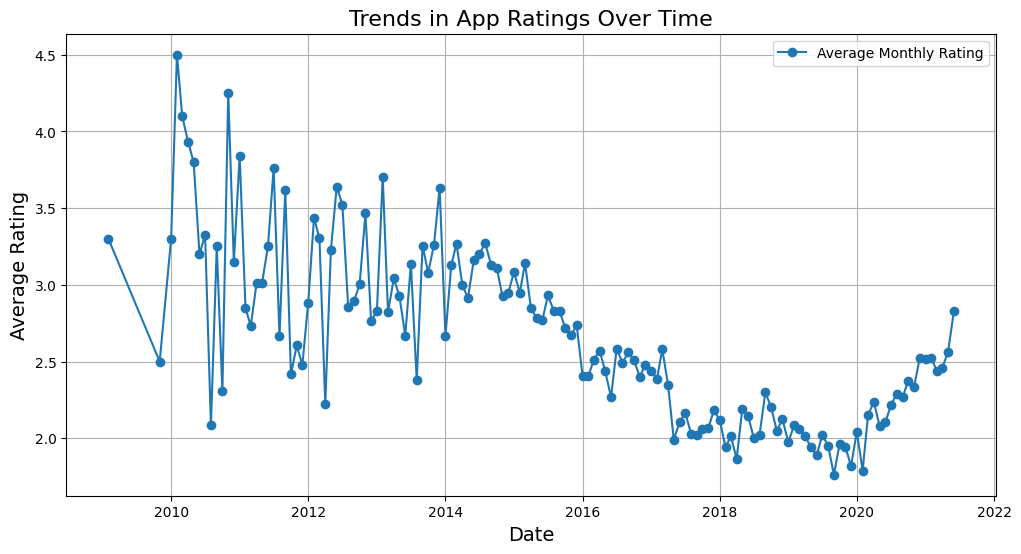

In [3]:
# Group data by month and calculate mean rating
df['Month'] = df['Last Updated'].dt.to_period('M')
monthly_ratings = df.groupby('Month')['Rating'].mean()

# Plot time-series trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_ratings.index.to_timestamp(), monthly_ratings, marker='o', label='Average Monthly Rating')
plt.title('Trends in App Ratings Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.grid()
plt.legend()
plt.show()


### Step 3: Forecasting Model

In [4]:
# Prepare Data for Forecasting

# Reset index for time-series forecasting
time_series = monthly_ratings.reset_index()
time_series.columns = ['Month', 'Rating']
time_series['Month'] = time_series['Month'].dt.to_timestamp()

# Split data into training and testing sets
train_size = int(len(time_series) * 0.8)
train_data = time_series[:train_size]
test_data = time_series[train_size:]


### Exponential Smoothing Model

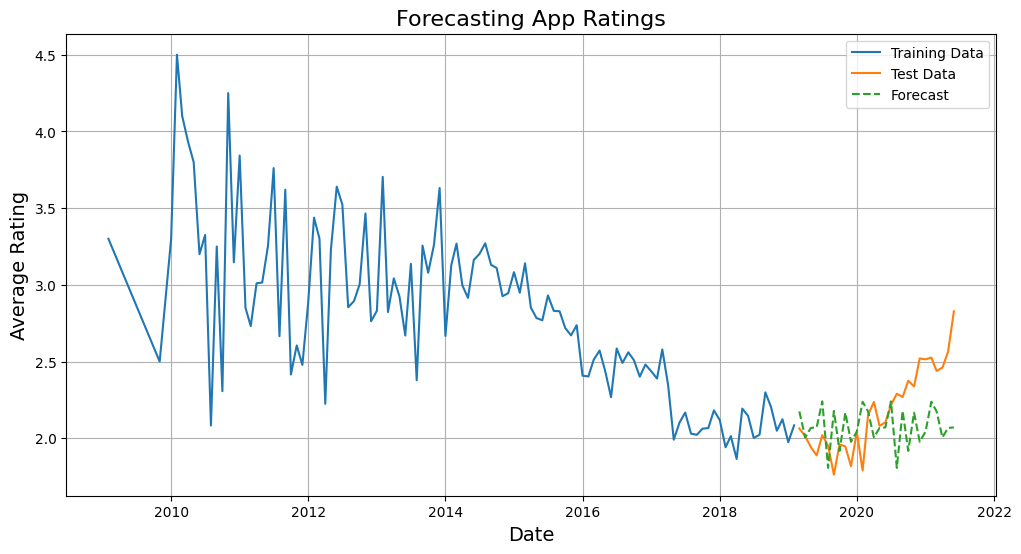

Mean Squared Error: 0.1004
R-squared: -0.4036


In [5]:
# Fit an Exponential Smoothing model
model = ExponentialSmoothing(
    train_data['Rating'], 
    seasonal='add', 
    seasonal_periods=12
).fit()

# Forecast
forecast = model.forecast(steps=len(test_data))

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data['Month'], train_data['Rating'], label='Training Data')
plt.plot(test_data['Month'], test_data['Rating'], label='Test Data')
plt.plot(test_data['Month'], forecast, label='Forecast', linestyle='--')
plt.title('Forecasting App Ratings', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.grid()
plt.legend()
plt.show()

# Evaluate Model
mse = mean_squared_error(test_data['Rating'], forecast)
r2 = r2_score(test_data['Rating'], forecast)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")


### Step 4: Feedback Loop

In [6]:
# User Interaction for Refinement

print("\nFeedback Options:")
print("1. Aggregate ratings by quarter instead of month.")
print("2. Apply transformation to handle missing or zero ratings.")
print("3. Retrain model with additional features (e.g., Category).")
print("4. Proceed without changes.")

# User input
choice = int(input("Enter your choice (1, 2, 3, or 4): "))

if choice == 1:
    # Aggregate by quarter
    df['Quarter'] = df['Last Updated'].dt.to_period('Q')
    quarterly_ratings = df.groupby('Quarter')['Rating'].mean()
    print("Aggregated by quarter. Re-plotting and re-training model...")
    # Update and re-visualize
    time_series = quarterly_ratings.reset_index()
    time_series.columns = ['Quarter', 'Rating']
    time_series['Quarter'] = time_series['Quarter'].dt.to_timestamp()
elif choice == 2:
    # Handle missing or zero ratings
    df['Rating'] = df['Rating'].replace(0, np.nan)
    df['Rating'].fillna(df['Rating'].mean(), inplace=True)
    print("Missing and zero ratings handled. Re-plotting and re-training model...")
elif choice == 3:
    # Add category feature to train/test split
    category_dummies = pd.get_dummies(df['Category'])
    df = pd.concat([df, category_dummies], axis=1)
    print("Additional features (Category) added. Re-training model...")
elif choice == 4:
    print("Proceeding without changes.")
else:
    print("Invalid choice. Proceeding without changes.")


Feedback Options:
1. Aggregate ratings by quarter instead of month.
2. Apply transformation to handle missing or zero ratings.
3. Retrain model with additional features (e.g., Category).
4. Proceed without changes.
Additional features (Category) added. Re-training model...


### Step 5: Re-Train and Evaluate

In [7]:
# Repeat the forecasting process based on updated data
# (Steps above can be re-used for retraining and re-evaluation)

# Example of re-training after aggregation
if choice == 1:
    train_size = int(len(time_series) * 0.8)
    train_data = time_series[:train_size]
    test_data = time_series[train_size:]

    model = ExponentialSmoothing(
        train_data['Rating'], 
        seasonal='add', 
        seasonal_periods=4  # Quarterly data
    ).fit()

    forecast = model.forecast(steps=len(test_data))

    # Re-plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['Quarter'], train_data['Rating'], label='Training Data')
    plt.plot(test_data['Quarter'], test_data['Rating'], label='Test Data')
    plt.plot(test_data['Quarter'], forecast, label='Forecast', linestyle='--')
    plt.title('Updated Forecasting App Ratings', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Average Rating', fontsize=14)
    plt.grid()
    plt.legend()
    plt.show()

    # Evaluate updated model
    mse = mean_squared_error(test_data['Rating'], forecast)
    r2 = r2_score(test_data['Rating'], forecast)
    print(f"Updated Mean Squared Error: {mse:.4f}")
    print(f"Updated R-squared: {r2:.4f}")
